# Fig 1

Monogenic resistance can give low doses better sometimes

NB check that current form for data etc is most up to date fit!!

In [213]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import pandas as pd

import seaborn as sns

from math import log

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist, Fungicide
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [226]:
sns.set_palette("viridis_r", n_colors=10)

In [227]:
cf = Config(
    verbose=False, 
    n_k=100,
    # n_years=200,
    n_years=20,
)

cf.mutation_proportion = 0
cf.mutation_scale_fung = 1
cf.mutation_scale_host = 1

cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 0
mutation_scale_fung = 1
mutation_scale_host = 1
n_k = 100
n_l = 50
n_years = 20
replace_cultivars = None
sprays = None



In [228]:
def get_mono_data(init_dist):
    doses = np.linspace(0,1,5)[1:]

    df = pd.DataFrame()

    for dd in doses:
        cf.doses = dd*np.ones(cf.n_years)

        sim = SimulatorOneTrait(cf)

        sim.initial_k_dist = init_dist

        data = sim.run_model()

        tmp = pd.DataFrame(
            dict(
                yld=data['yield_vec'],
                dose=dd,
                year=data['year'],
                mean=data['fung_mean'][:-1],
            ))

        df = pd.concat([df, tmp])

    df = df.reset_index(drop=True)
    
    return df

In [229]:
pr = 1e-3

In [230]:
init_dist_1 = np.zeros(cf.n_k)
init_dist_1[20] = 1-pr
init_dist_1[-1] = pr

df_lo = get_mono_data(init_dist_1)

In [231]:
init_dist_2 = np.zeros(cf.n_k)
init_dist_2[20] = 1-pr
init_dist_2[-20] = pr

df_hi = get_mono_data(init_dist_2)

In [232]:
init_dist_3 = np.zeros(cf.n_k)
init_dist_3[20] = 1-pr
init_dist_3[50] = pr

df_ex = get_mono_data(init_dist_3)

In [233]:
def fung_effect(tv, dose):
    curv = log(1/tv)
    return np.exp(- curv*dose)

In [234]:
doses = np.linspace(0,1,100)

dr_ls = fung_effect(tv[20], doses)
dr_lr = fung_effect(tv[-1], doses)

dr_hs = fung_effect(tv[20], doses)
dr_hr = fung_effect(tv[-20], doses)

dr_es = fung_effect(tv[20], doses)
dr_er = fung_effect(tv[50], doses)

In [235]:
tv[20], tv[-1], 'ok', tv[20], tv[-20], 'ok', tv[20], tv[50]

(0.20500000000000002,
 0.995,
 'ok',
 0.20500000000000002,
 0.805,
 'ok',
 0.20500000000000002,
 0.505)

In [238]:
pd.concat([df_lo, df_hi, df_ex]).describe().loc[['min', 'max']]

,yld,dose,year,mean
min,8.815626,0.25,1.0,0.2053
max,10.216334,1.00,20.0,0.9950


In [249]:
sns.color_palette('viridis_r', n_colors=6)

[(0.626579, 0.854645, 0.223353),
 (0.288921, 0.758394, 0.428426),
 (0.122312, 0.633153, 0.530398),
 (0.153364, 0.497, 0.557724),
 (0.212395, 0.359683, 0.55171),
 (0.275191, 0.194905, 0.496005)]

In [335]:
def cbar_fn(df):
    tmp = (
        df
        .loc[:, ['yld', 'dose', 'year']]
        .groupby('year')
        .apply(lambda x: x.loc[x.yld.idxmax()])
        .assign(yy=10.4)
        .reset_index(drop=True)
    )
    
    # wanted e.g. 1 becomes 0.5 to 1.5, 
    # but because lw so thick needed to make smaller (i.e. not 0.5)
    out_lo = tmp.assign(year=lambda x: x.year-0.1)
    out_hi = tmp.assign(year=lambda x: x.year+0.1)
    
    out = (
        pd.concat([
            out_lo,
            out_hi
        ])
        .sort_values('year')
        .drop('yld', axis=1)
        .drop_duplicates()
    )
    
    return out

In [336]:
lo_cols = cbar_fn(df_lo)
hi_cols = cbar_fn(df_hi)
ex_cols = cbar_fn(df_ex)

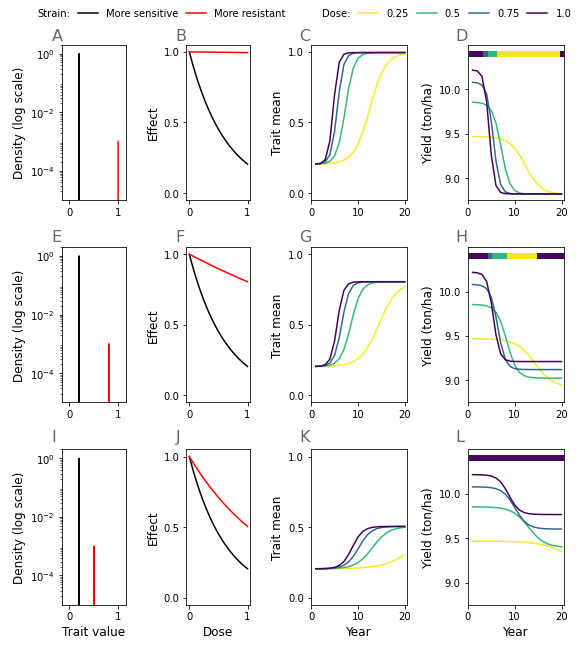

In [337]:
f, ax = plt.subplots(
    3,
    4, 
    figsize=(8,9),
    gridspec_kw={'width_ratios':[2,2,3,3]},
)

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
# plt.rc('legend', fontsize=11)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

tv = trait_vec(cf.n_k)

sns.lineplot(
    x='year',
    y='mean',
    hue='dose',
    data=df_lo,
    ax=ax[0][2],
    palette='viridis_r',
    legend=True,
)

sns.lineplot(
    x='year',
    y='mean',
    hue='dose',
    data=df_hi,
    ax=ax[1][2],
    palette='viridis_r',
    legend=False,
)

sns.lineplot(
    x='year',
    y='mean',
    hue='dose',
    data=df_ex,
    ax=ax[2][2],
    palette='viridis_r',
    legend=False,
)

## YIELD
sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_lo,
    ax=ax[0][3],
    palette='viridis_r',
    legend=False,
)

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_hi,
    ax=ax[1][3],
    palette='viridis_r',
    legend=False,
)

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_ex,
    ax=ax[2][3],
    palette='viridis_r',
    legend=False,
)

ax[0][1].plot([], [], ' ', label="Dose:")

ax[0][0].plot([], [], ' ', label="Strain:")

ax[0][0].plot(tv[:30], init_dist_1[:30], c='k', label='More sensitive')
ax[1][0].plot(tv[:30], init_dist_2[:30], c='k')
ax[2][0].plot(tv[:30], init_dist_3[:30], c='k')

ax[0][0].plot(tv[30:], init_dist_1[30:], c='r', label='More resistant')
ax[1][0].plot(tv[30:], init_dist_2[30:], c='r')
ax[2][0].plot(tv[30:], init_dist_3[30:], c='r')

# ax[0][0].plot([], [], ' ', label="s")
# ax[0][0].plot([], [], ' ', label="s")
# ax[0][0].plot([], [], ' ', label="s")


ax[0][0].set_yscale('log')
ax[1][0].set_yscale('log')
ax[2][0].set_yscale('log')


ax[0][1].plot(doses, dr_ls, c='k')
ax[0][1].plot(doses, dr_lr, c='r')

ax[1][1].plot(doses, dr_hs, c='k')
ax[1][1].plot(doses, dr_hr, c='r')

ax[2][1].plot(doses, dr_es, c='k')
ax[2][1].plot(doses, dr_er, c='r')

# color bars

COLZ = sns.color_palette('viridis_r', n_colors=60)

c1 = COLZ[0]
c2 = COLZ[20]
c3 = COLZ[40]
c4 = COLZ[-1]

lw = 6

ax[0][3].plot(lo_cols.loc[lambda x: x.dose==1].year,
              lo_cols.loc[lambda x: x.dose==1].yy, c=c4, lw=lw)

ax[0][3].plot(lo_cols.loc[lambda x: x.dose==0.75].year,
              lo_cols.loc[lambda x: x.dose==0.75].yy, c=c3, lw=lw)

ax[0][3].plot(lo_cols.loc[lambda x: x.dose==0.5].year,
              lo_cols.loc[lambda x: x.dose==0.5].yy, c=c2, lw=lw)

ax[0][3].plot(lo_cols.loc[lambda x: x.dose==0.25].year,
              lo_cols.loc[lambda x: x.dose==0.25].yy, c=c1, lw=lw)


ax[1][3].plot(hi_cols.loc[lambda x: x.dose==1].year,
              hi_cols.loc[lambda x: x.dose==1].yy, c=c4, lw=lw)

ax[1][3].plot(hi_cols.loc[lambda x: x.dose==0.75].year,
              hi_cols.loc[lambda x: x.dose==0.75].yy, c=c3, lw=lw)

ax[1][3].plot(hi_cols.loc[lambda x: x.dose==0.5].year,
              hi_cols.loc[lambda x: x.dose==0.5].yy, c=c2, lw=lw)

ax[1][3].plot(hi_cols.loc[lambda x: x.dose==0.25].year,
              hi_cols.loc[lambda x: x.dose==0.25].yy, c=c1, lw=lw)


ax[2][3].plot(ex_cols.loc[lambda x: x.dose==1].year,
              ex_cols.loc[lambda x: x.dose==1].yy, c=c4, lw=lw)

ax[2][3].plot(ex_cols.loc[lambda x: x.dose==0.75].year,
              ex_cols.loc[lambda x: x.dose==0.75].yy, c=c3, lw=lw)

ax[2][3].plot(ex_cols.loc[lambda x: x.dose==0.5].year,
              ex_cols.loc[lambda x: x.dose==0.5].yy, c=c2, lw=lw)

ax[2][3].plot(ex_cols.loc[lambda x: x.dose==0.25].year,
              ex_cols.loc[lambda x: x.dose==0.25].yy, c=c1, lw=lw)



# axis limits

ax0range=[-0.15, 1.15]

ax[0][0].set_xlim(ax0range)
ax[1][0].set_xlim(ax0range)
ax[2][0].set_xlim(ax0range)



x_lim = [0, 20.5]

ax[0][2].set_xlim(x_lim)
ax[1][2].set_xlim(x_lim)
ax[2][2].set_xlim(x_lim)

ax[0][3].set_xlim(x_lim)
ax[1][3].set_xlim(x_lim)
ax[2][3].set_xlim(x_lim)



ax[0][0].set_ylim([1e-5, 2])
ax[1][0].set_ylim([1e-5, 2])
ax[2][0].set_ylim([1e-5, 2])

ax[0][1].set_ylim([-0.05, 1.05])
ax[1][1].set_ylim([-0.05, 1.05])
ax[2][1].set_ylim([-0.05, 1.05])

ax[0][2].set_ylim([-0.05, 1.05])
ax[1][2].set_ylim([-0.05, 1.05])
ax[2][2].set_ylim([-0.05, 1.05])

ylims3 = [8.75, 10.50]

ax[0][3].set_ylim(ylims3)
ax[1][3].set_ylim(ylims3)
ax[2][3].set_ylim(ylims3)


# set yticks

yticks0 = [1e-4, 1e-2, 1]
ax[0][0].set_yticks(yticks0)
ax[1][0].set_yticks(yticks0)
ax[2][0].set_yticks(yticks0)

yticks2 = [0, 0.5, 1]
ax[0][1].set_yticks(yticks2)
ax[1][1].set_yticks(yticks2)
ax[2][1].set_yticks(yticks2)

ax[0][2].set_yticks(yticks2)
ax[1][2].set_yticks(yticks2)
ax[2][2].set_yticks(yticks2)

yticks3 = [9, 9.5, 10]
ax[0][3].set_yticks(yticks3)
ax[1][3].set_yticks(yticks3)
ax[2][3].set_yticks(yticks3)


# Axis labels

ax[2][0].set_xlabel('Trait value')
ax[2][1].set_xlabel('Dose')
ax[2][2].set_xlabel('Year')
ax[2][3].set_xlabel('Year')

ax[0][0].set_xlabel(None)
ax[1][0].set_xlabel(None)
ax[0][1].set_xlabel(None)
ax[1][1].set_xlabel(None)
ax[0][2].set_xlabel(None)
ax[1][2].set_xlabel(None)
ax[0][3].set_xlabel(None)
ax[1][3].set_xlabel(None)

ax[0][0].set_ylabel('Density (log scale)')
ax[1][0].set_ylabel('Density (log scale)')
ax[2][0].set_ylabel('Density (log scale)')

ax[0][1].set_ylabel('Effect')
ax[1][1].set_ylabel('Effect')
ax[2][1].set_ylabel('Effect')

ax[0][2].set_ylabel('Trait mean')
ax[1][2].set_ylabel('Trait mean')
ax[2][2].set_ylabel('Trait mean')

ax[0][3].set_ylabel('Yield (ton/ha)')
ax[1][3].set_ylabel('Yield (ton/ha)')
ax[2][3].set_ylabel('Yield (ton/ha)')

plt.tight_layout(rect=[0,0,1,0.95], h_pad=3)

y0 = 0.935
yg = 0.31

x0 = 0.09
xg1 = 0.215
xg2 = 0.27

ys = [y0 - ii*yg for ii in np.arange(3)]
xs = [x0, x0 + xg1, x0 + 2*xg1, x0 + 2*xg1 + xg2]

get_corner_annotations_explicit(4, 3, xs, ys, plt)

# ax[0][0].legend(bbox_to_anchor=(1.1, 1.05))
ax[0][2].legend(handles=[], frameon=False)

f.legend(
    loc=1, 
    ncol=9,
    mode='expand',
    framealpha=0,
)

## Save

In [338]:
f.savefig('../figures/paper/fig1.jpg', dpi=300, bbox_inches="tight")

## testing

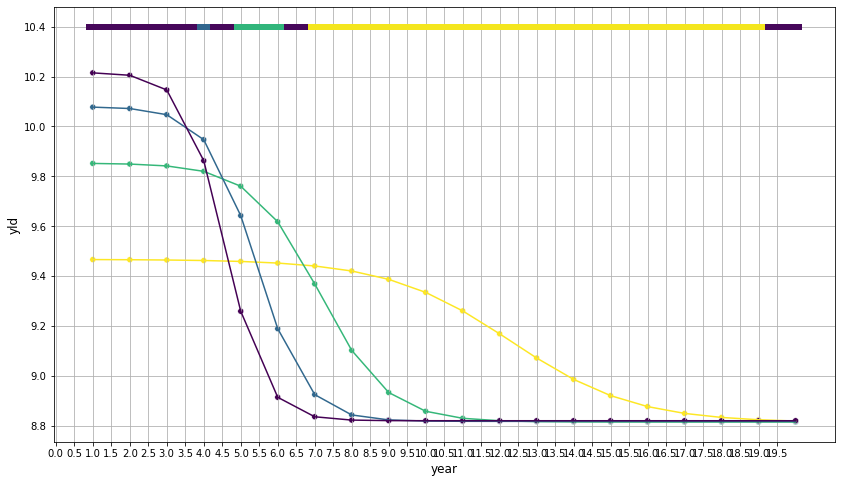

In [327]:
f, ax = plt.subplots(figsize=(14,8))

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_lo,
    ax=ax,
    palette='viridis_r',
    legend=False,
)

sns.scatterplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_lo,
    ax=ax,
    palette='viridis_r',
    legend=False,
)

COLZ = sns.color_palette('viridis_r', n_colors=60)

c1 = COLZ[0]
c2 = COLZ[20]
c3 = COLZ[40]
c4 = COLZ[-1]

lw = 6

ax.plot(lo_cols.loc[lambda x: x.dose==1].year,
        lo_cols.loc[lambda x: x.dose==1].yy, 
        c=c4, lw=lw)

ax.plot(lo_cols.loc[lambda x: x.dose==0.75].year,
        lo_cols.loc[lambda x: x.dose==0.75].yy,
        c=c3, lw=lw)

ax.plot(lo_cols.loc[lambda x: x.dose==0.5].year,
        lo_cols.loc[lambda x: x.dose==0.5].yy, 
        c=c2, lw=lw)

ax.plot(lo_cols.loc[lambda x: x.dose==0.25].year,
        lo_cols.loc[lambda x: x.dose==0.25].yy, 
        c=c1, lw=lw)

ax.set_xticks(np.arange(0,20,0.5))
ax.grid()
# ax.grid(which='minor')
# plt.minorticks_on()